In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer    # 
from wordcloud import WordCloud                                # Generate word clouds

from tqdm import tqdm  # Progress bar

# Stopwords (common words)
# nltk.download('stopwords')  # Stopwords must be downloaded
from nltk.corpus import stopwords

# Inspect data

We read in and inspect the data

The training data rows contain a `keyword`, a `location` (sometimes not present), `text` containg a tweet and a `target` coding 1 for disaster and 0 for non-disaster.

The training data contains 7613 observations, while the test data contains 3263 observations.

In [2]:
tweet= pd.read_csv('./input/nlp-getting-started/train.csv')
test=pd.read_csv('./input/nlp-getting-started/test.csv')

In [3]:
tweet.iloc[200]

id                                                        281
keyword                                             ambulance
location                            VISIT MY YOUTUBE CHANNEL.
text        HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPOND...
target                                                      0
Name: 200, dtype: object

In [4]:
tweet.iloc[200:203]

,id,keyword,location,text,target
200,281,ambulance,VISIT MY YOUTUBE CHANNEL.,HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPOND...,0
201,283,ambulance,Lexington,http://t.co/FueRk0gWui Twelve feared killed in...,1
202,285,ambulance,NaN,http://t.co/X5YEUYLT1X Twelve feared killed in...,1


Location does not seem trustworthy.

In [5]:
print(tweet.shape)
print(test.shape)

(7613, 5)
(3263, 4)


By inspecting a few tweets we see that we need to clean the text before we can analyze it.

In [6]:
for i in [677, 2643, 3134, 92, 2290, 2062, 3681, 2343, 2384, 323]:
    print(str(tweet.iloc[i]["target"]) + ": " + tweet.iloc[i]["text"])

0: https://t.co/WKv8VqVkT6 #ArtisteOfTheWeekFact say #Conversations by #coast2coastdjs agree @Crystal_Blaz 's #Jiwonle is a #HipHop #ClubBanger
1: RSS: Russia begins mass destruction of illegally imported food   http://t.co/r6JDj9kIGm
1: Emergency Flow  http://t.co/lH9mrYpDrJ mp3 http://t.co/PqhuthSS3i rar http://t.co/0iW6dRf5X9
1: 8/6/2015@2:09 PM: TRAFFIC ACCIDENT NO INJURY at 2781 WILLIS FOREMAN RD http://t.co/VCkIT6EDEv
0: Absurdly Ridiculous MenÛªs #Fashion To Demolish You #Manhood. http://t.co/vTP8i8QLEn
0: i miss my longer hair..but it was so dead anyways it wasn't even hair
0: @Babybackreeve FATALITY!!!!!!!!!!
1: Demolition Means Progress: Flint Michigan and the Fate of the American Metropolis Highsmith https://t.co/ZvoBMDxHGP
1: How do you derail a train at... Smithsonian?
0: @paddytomlinson1 ARMAGEDDON


We see that
- There are many unusual symbols, such as in "MenÛªs", and hashtags (#)
- We need to remove urls
- Many tweets have date tags, such as "8/6/2015@2:09 PM:"

## Keywords
The keyword column contain an important keyword present in the tweet, such as "sinking".

In [7]:
tweet[tweet['keyword']=='sinking'][["text", "target"]].head(10)

,text,target
6085,Do you feel like you are sinking in low self-i...,0
6086,After a Few Years Afloat Pension Plans Start S...,1
6087,Do you feel like you are sinking in unhappines...,0
6088,With a sinking music video tv career Brooke Ho...,0
6089,@supernovalester I feel so bad for them. I can...,0
6090,#nowplaying Sinking Fast - Now or Never on Nor...,0
6091,that horrible sinking feeling when youÛªve be...,1
6092,Nigga car sinking but he snapping it up for fo...,0
6093,@abandonedpics You should delete this one it's...,0
6094,that horrible sinking feeling when youÛªve be...,0


It looks like I found a contradiction in the dataset:

In [8]:
for i in [6091, 6094]:
    print("\n-Target: ",tweet.iloc[i].target)
    print("-Tweet: \n", tweet.iloc[i].text)


-Target:  1
-Tweet: 
 that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time

-Target:  0
-Tweet: 
 that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time


TODO: 
- Inspect if there are many of these
  - Find number of duplicate tweets

In [9]:
tweet.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

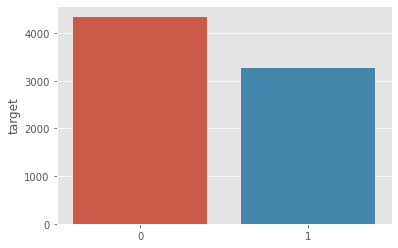

In [10]:
value_dist = tweet.target.value_counts()

sns.barplot(x=value_dist.index, y=value_dist)
plt.show()

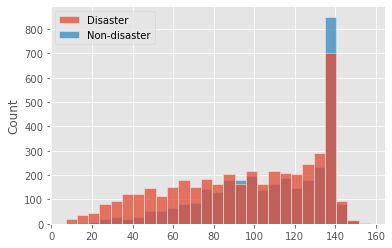

In [11]:
tw_len = tweet.text.str.len()

dta = {k:v for (k,v) in zip(["Disaster", "Non-disaster"], [tw_len[tweet.target==i] for i in [0,1]])}
sns.histplot(dta)
plt.show()

# Sentiment analysis
We will try adding a sentiment analysis score to our tweets. `SentimentIntensityAnalyzer` from `nltk` gives pieces of text a sentiment score between -1 and 1, where 1 is very positive and -1 is very negative

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

sia_table = []
for tweet_i in tweet['text']:
    sia_table.append(sia.polarity_scores(tweet_i)['compound'])

In [13]:
tweet['sentiment'] = sia_table

We inspect ten random tweets

In [14]:
print(f"Target | Sentiment | Tweet")
for i, row in tweet.iloc[[5585, 1708, 2297, 2759, 6229, 7439, 1766, 5314, 5725, 1582]].iterrows():
    print(f"{row.target:6} | {row.sentiment:9.4f} | {row.text}")

Target | Sentiment | Tweet
     1 |    0.0000 | http://t.co/iXiYBAp8Qa The Latest: More homes razed by Northern California wildfire - Lynchburg News and Advance http://t.co/zEpzQYDby4
     0 |    0.6636 | Reading for work has collided with reading for pleasure. Huzzah. Don't miss @molly_the_tanz's Vermilion! http://t.co/83bMprwH7W
     0 |    0.0000 | think i'll become a businessman a demolish a community centre and build condos on it but foiled by a troupe of multi-racial breakdancers .
     1 |   -0.8481 | 70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/LtVVPfLSg8
     0 |    0.0000 | 'Snowstorm' 36'x36' oil on canvas (2009) http://t.co/RCZAlRU05o #art #painting
     0 |    0.0000 | We would become the mirrors that reflected each other's most private wounds and desires.
     1 |   -0.6369 | #Colorado #News Motorcyclist bicyclist injured in Denver collision on Broadway: At least two people were tak... http://

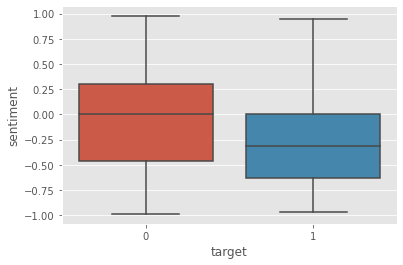

In [15]:
sns.boxplot(x=tweet.target, y=tweet.sentiment)
plt.show()

Sentiment of disaster tweets seem to fall slightly lower than non-disaster tweets on average. It might have stronger predictive quality together with high leverl features of the tweets discovered by the neural network. 

Sentiment does not seem to separate the two classes, but might be predictive in connection with higher level features detected by the neural network.
- TODO: How to implement sentiment in the analysis?

# Ngram analysis
- Uninformative
- From https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Exploratory-Data-Analysis-of-tweets

In [16]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Visualize common words within groups

- TODO: Remove

(-0.5, 399.5, 199.5, -0.5)

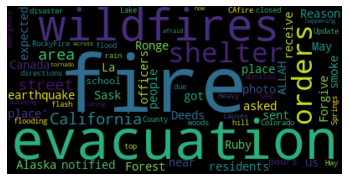

In [17]:
# Temp, test WordCloud
wordcloud = WordCloud().generate(",".join(tweet.head(10).text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Clean tweets
- TODO Colons are not removed

We replace ascii %20 with space in the keywords

In [18]:
list(tweet.keyword.unique())[30]

'body%20bags'

In [19]:
test.keyword =  test.keyword.str.replace("%20", " ")
tweet.keyword = tweet.keyword.str.replace("%20", " ")

In [20]:
list(tweet.keyword.unique())[30]

'body bags'

- TODO inplace editing

In [21]:
tweet.text.iloc[3639]

'Mortal Kombat X: All Fatalities On Meat Predator.\nhttps://t.co/IggFNBIxt5'

In [22]:
def clean_data(df: pd.DataFrame):
    import string
    import re

    punctuation_regex = re.compile(f"[{re.escape(string.punctuation)}:]")
    emoji_pattern = re.compile("["
                               "\U0001F600-\U0001F64F"  # emoticons
                               "\U0001F300-\U0001F5FF"  # symbols & pictographs
                               "\U0001F680-\U0001F6FF"  # transport & map symbols
                               "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "\U00002702-\U000027B0"  # Symbols
                               "\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    # Clean training data
    df.text = df.text.str.lower()
    df.text = df.text.str.replace(r"https[^\s|$]*", "URL", regex=True)  # Change all urls to "URL"
    df.text = df.text.str.replace(punctuation_regex, "", regex=True)
    df.text = df.text.str.replace(emoji_pattern, "", regex=True)  # Remove emojis and symbols
    df.text = df.text.str.replace(r"\n", " ", regex = True)       # Change \n to space
    df.text = df.text.str.replace(r"[^a-zA-Z0-9 ]", "", regex=True)  # Remove last non word characters
    df.text = df.text.str.replace(r"<.*?>", "", regex=True)  # Remove html tags (e.g. <div> )

    return df

In [23]:
tweet = clean_data(tweet)
test = clean_data(test)

In [24]:
tweet.text.iloc[3639]

'mortal kombat x all fatalities on meat predator URL'

## Acronyms and joined words in tweets
Many tweets contain acronyms and joined words, such as #arianagrande. These will not have a pre-trained embedding.
We could
- Check out "a la carte embeddings" (https://arxiv.org/abs/1805.05388)
- https://www.reddit.com/r/LanguageTechnology/comments/g4r39s/whats_the_simplest_way_to_generate_word_vectors/
  - "You can use Magnitude (open source vector embedding library) to automatically handle out of vocabulary words for FastText, word2vec, GloVe, or ELMo" (https://github.com/plasticityai/magnitude)
- Ignore them, and hope they are not important for disaster tweet prediction.
- Code each unknown word as <unk>. Maybe usage of a word that is not in a common dictionary is predictive for disaster tweets.
- Fine tune the string embeddings on our tweets.

In [25]:
tweet.text[5968]

'arianagrande justinbieber im screaming omg idols 22days wdym'

In [26]:
tweet.text[6533]

'thedailyshow mahalo nui loa for making my 20s my generation could not have survived the w bush years without you jonvoyage holomua'

In [27]:
tweet.text[tweet.text.str.match(r".*jonvoyage")]

5161    gop debate tonight but no jon stewart next wee...
6533    thedailyshow mahalo nui loa for making my 20s ...
Name: text, dtype: object

# Spell correction

In [28]:
!pip install pyspellchecker
# !conda install -c conda-forge pyspellchecker

In [29]:
from spellchecker import SpellChecker

In [30]:
spell = SpellChecker()

misspelled = spell.unknown(['something', 'is', 'hapenning', 'here'])

for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))

    # Get a list of `likely` options
    print(spell.candidates(word))

happenning
{'hapening', 'happenning'}


Seems to work nicely.

Implementation copied from https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

In [31]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

- TODO implement in data clean block with apply

# Preparing the data
We need to convert the text to sequences as input to the model

## Corpus
We first create a corpus, removing stop words
- TODO: Try keeping stopwords

In [32]:
def create_corpus(text: pd.core.series.Series):
    """
    Creates a corpus while filtering out stop words and non-alphanumeric words
    """
    
    from nltk.tokenize import word_tokenize  # Tokenize words
    
    stop=set(stopwords.words('english'))
    corpus = []
    for tw in tqdm(text):   # For loop with progress bar
        words = [word for word in word_tokenize(tw) if ((word.isalpha()) & (not word in stop))]
        corpus.append(words)
    return corpus

We create a corpus from the training and test dataset. We will later split the data back into training and test data using the correct index.

In [33]:
# We create a corpus from the training and test dataset. We will later split the data back into training and test data using the correct index.
corpus = create_corpus(tweet.text.append(test.text))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10876/10876 [00:01<00:00, 6312.99it/s]


# Saving objects
We create some reuseable code for saving objects for later use, so we don't have to re-run time consuming code.

In [34]:
import pickle
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

### Tokenization
We tokenize the tweets using helper functions from `keras`

In [35]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer_object = Tokenizer()

In [36]:
# Tokenize the words in the corpus
tokenizer_object.fit_on_texts(corpus)

# Create sequences from the text in the corpus. The words are now coded to numbers.
sequences = tokenizer_object.texts_to_sequences(corpus)

# We pad the tweets so that the model has input of equal length. Padding the start of text sequences seems to be the most widely used.
MAX_LEN = 50
tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='pre', padding='pre')

# Save the tokenizer object
save_obj(tokenizer_object, "tokenizer_object")
save_obj(tweet_pad, "tweet_pad")

In [37]:
# Load previously created tokenizer
tokenizer_object = load_obj("tokenizer_object")
tweet_pad = load_obj("tweet_pad")

## Word embedding vectorization
We will first vectorize words using a library of vectors from a pre trained model.

- TODO: Fine tune on current dataset
  - see demo.sh in the github repo
- Alternative dataset: https://allennlp.org/elmo


We will use GloVe for vectorization of words found at https://github.com/stanfordnlp/GloVe,
trying the twitter dataset first.

In [38]:
# import mmap

def get_num_lines(file_path: str):
    """
    Get the number of lines in a file. 
    Used in the tqdm module to get a progress bar for 
    for-loops when iterating over lines in a file.
    """
    fp = open(file_path, "r+")
    buf = mmap.mmap(fp.fileno(), 0)
    lines = 0
    while buf.readline():
        lines += 1
    return lines

In [39]:
# # Run this once to save an embedding dictionary to a file in and obj/ folder in current dir (obj dir must be created beforehand)
# embedding_dict={}
# file_path = './input/glove.twitter.27B.100d.txt'
# with open(file_path,'r') as f:
#     for line in tqdm(f, total = get_num_lines(file_path)):
#         values=line.split()
#         word=values[0]
#         vectors=np.asarray(values[1:],'float32')
#         embedding_dict[word]=vectors
# f.close()

# save_obj(embedding_dict, "embedding_dict")

In [ ]:
# Load saved embedding dictionary from previous cell
embedding_dict = load_obj("embedding_dict")

- TODO: Visualize embeddings with PCA

### Create embedding matrix
We create the embedding matrix, where each row is a pre-trained word embedding vector from the GloVe dictionary, and where row index coincides with the word token.


- TODO:For the index in the matrix to match the word tokens the embedding_matrix is padded with an initial row of zeros because tokenization starts at 1, while python list index starts at 0

In [ ]:
word_index = tokenizer_object.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word,i in tqdm(word_index.items(), total = len(word_index.items())):
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i,:]=emb_vec

save_obj(embedding_matrix, "embedding_matrix")

In [2]:
save_obj(embedding_matrix, "embedding_matrix")
embedding_matrix = load_obj("embedding_matrix")

NameError: name 'save_obj' is not defined

## We initialize the embedding layer for the model
The embedding layer is a flexible layer that can be used in a variety of ways:
- It can be used alone to learn a word embedding that can be saved and used in another model later.
- It can be used as part of a deep learning model where the embedding is learned along with the model itself.
- It can be used to load a pre-trained word embedding model, a type of transfer learning.


In [ ]:
from keras.layers import Embedding

embedding = Embedding(input_dim  = num_words,
                      output_dim = 100,
                      embeddings_initializer = Constant(embedding_matrix),
                      input_length = MAX_LEN,
                      mask_zero = True,  # Boolean, whether or not the input value 0 is a special "padding" value that should be masked out.
                     )

TODO: 
- mask_zero in Embedding?
- Train embeddings on our corpus.

In [ ]:
# !pip install tensorflow  # tensorflog-cpu for laptop withoug gpu

# Model creation
We now create our model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant

## Building the model
We then set up our model
- TODO: What type of dropout to apply? (see discussion here https://github.com/keras-team/keras/issues/7290)

In [ ]:
model = Sequential()
model.add(embedding)
model.add(SpatialDropout1D(0.2))  # Dropout to reduce overfitting.
model.add(LSTM(64,
               dropout=0.2,  # Fraction of the units to drop for the linear transformation of the inputs.
               recurrent_dropout=0.2  # Fraction of the units to drop for the linear transformation of the recurrent state.
              ))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model.summary()

## Split into training and test set
We split the training data into a training and test set for model optimization.
We choose test set size to be 15 % of the data, the remaining 85 % is used for training.

In [ ]:
#We split our data sequences back into the original training and test data.
train_data = tweet_pad[:7613, :]
test_data = tweet_pad[7613:, :]

# We split the training data into a training and test set for the model fitting
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_data,
                                                    tweet['target'].values,
                                                    test_size=0.15)
print('Shape of train',x_train.shape)
print("Shape of Validation ",x_val.shape)

# Training the model

In [ ]:
# %%time

history = model.fit(x_train, y_train,
                    batch_size=4,
                    epochs=15,
                    validation_data=(x_val, y_val),
                    verbose=2)

# Save the fitted model to a file
model.save('./obj/')

In [ ]:
# Loading the fitted model from file:

from tensorflow import keras
model = keras.models.load_model('./obj/')

In [ ]:
axes = sns.lineplot(data=pd.DataFrame(history.history)[["accuracy", "loss"]])

In [ ]:
axes = sns.lineplot(data=pd.DataFrame(history.history)[["val_accuracy", "val_loss"]])

Accuracy and loss seem to decrease on the validation set. This does not bode well.

In [ ]:
# predictions = model.predict(test_data)

## TODO
- Inspect misclassified tweets
- Compare to pretrained CNN
- Try larger word embedding
- Experiment with dropout

## Misclassified tweets

In [143]:
y_pre=model.predict(test)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

# TODO
- Remove non words
- encode urls?
- Encode complexity of text: https://pypi.org/project/textstat/
- Removal of stop words (library for specific language)
- Remove URL's
- Spelling/grammar correction?
  - Companies like Google and Microsoft have achieved a decent accuracy level in automated spell correction. One can use algorithms like the Levenshtein Distances, Dictionary Lookup etc. or other modules and packages to fix these errors.
  - Number of misspelled words

- Try Neural Turing Machine (attention): https://github.com/carpedm20/NTM-tensorflow
- End-To-End Memory Networks: https://github.com/carpedm20/MemN2N-tensorflow
- Adaptive Computation Time algorithm https://github.com/DeNeutoy/act-tensorflow

## Saving the notebook environment variables

In [ ]:
# Saving environment
import dill
# save
dill.dump_session('notebook_env.db')

# load
dill.load_session('notebook_env.db')

## Split joined words

In [530]:
" ".join(re.findall('[A-Z][^A-Z]*', "HeiOgHaa"))

'Hei Og Haa'

## Remove duplicate letters
Needs improvements

In [532]:
import itertools
''.join(''.join(s)[:2] for _, s in itertools.groupby("I loooove you!"))

'I loove you!'

# Remove stopwords
We can use NLTK to remove common words.
These words contain little information on their own, but they might convey information in the sentence structure.

In [533]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/home/jonaso/nltk_data'
    - '/home/jonaso/anaconda3/nltk_data'
    - '/home/jonaso/anaconda3/share/nltk_data'
    - '/home/jonaso/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


## Remove contractions
Copied from https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['reviews.text']=df['reviews.text'].apply(lambda x:expand_contractions(x))

## Keywords
We now focus on tweets of selected keywords

### Most used words in the fatalities keyword category

In [95]:
selected_tweets = tweet[tweet.keyword == "fatalities"]

# list of words in selected tweets
list_of_words = [re.sub("", "", x).lower().split() for x in selected_tweets.text]

# Flatten nested lists
list_of_words = [item for sublist in list_of_words for item in sublist]

In [93]:
pd.DataFrame({"words":list_of_words}).words.value_counts().head(20)

fatalities    40
in            15
the           14
to            14
and           13
of            10
for            9
mortal         8
kombat         8
a              7
on             6
no             6
are            6
as             5
i              5
have           4
our            4
how            4
url            4
at             4
Name: words, dtype: int64

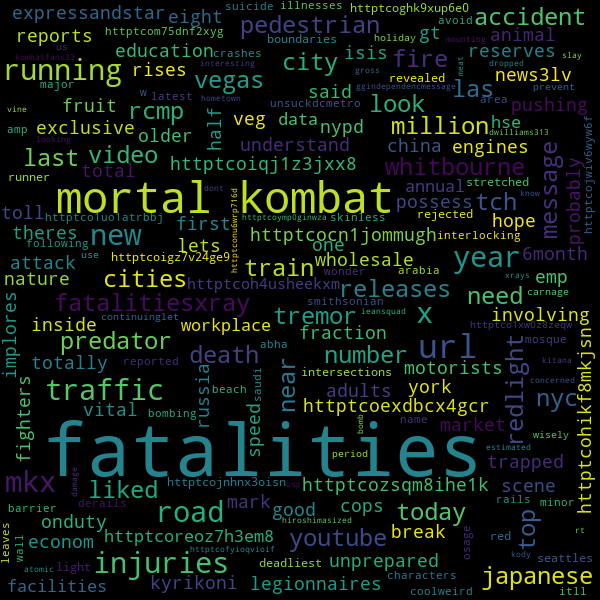

In [97]:
WordCloud(height=600, width=600, max_words=200).generate(",".join(list_of_words)).to_image()